In [1]:
%matplotlib inline
import composeml as cp
import featuretools as ft
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

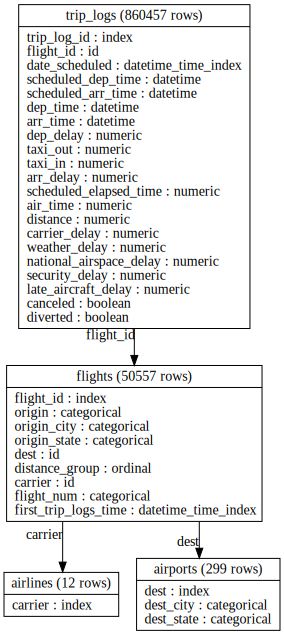

In [2]:
es = ft.demo.load_flight()
es.plot()

In [3]:
def flight_delay(df):
    diff = df.arr_time.sub(df.scheduled_arr_time)
    seconds = diff.abs().mean().total_seconds()
    return seconds / 60

In [4]:
lm = cp.LabelMaker(
    target_entity='flight_id',
    labeling_function=flight_delay,
    time_index='date_scheduled',
    window_size='1d',
)

In [5]:
lt = lm.search(
    es['trip_logs'].df,
    num_examples_per_instance=3,
    minimum_data='2016-10-20',
    verbose=True,
)

Elapsed: 02:40 | Remaining: 00:00 | Progress: 100%|██████████| flight_id: 151671/151671 


In [6]:
lt_thresh = lt.threshold(15)

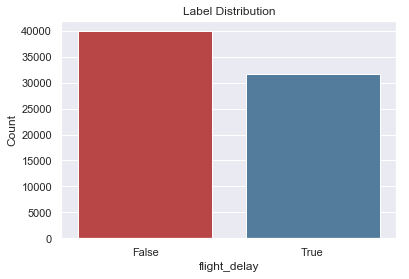

In [7]:
lt_thresh.plot.distribution();

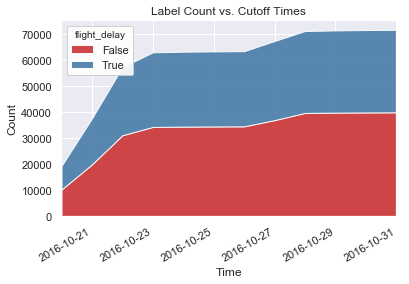

In [8]:
lt_thresh.plot.count_by_time();

In [9]:
n = {True: 20000, False: 20000}
cutoff_time = lt_thresh.sample(n=n, random_state=0)

In [10]:
cutoff_time.describe()

Label Distribution
------------------
False     20000
True      20000
Total:    40000


Settings
--------
gap                                  None
label_type                       discrete
labeling_function            flight_delay
minimum_data                   2016-10-20
num_examples_per_instance               3
target_entity                   flight_id
window_size                         <Day>


Transforms
----------
1. threshold
  - value:    15

2. sample
  - frac:                                   None
  - n:               {True: 20000, False: 20000}
  - random_state:                              0
  - replace:                               False



In [11]:
fm, fd = ft.dfs(
    target_entity='flights',
    entityset=es,
    cutoff_time=cutoff_time,
    cutoff_time_in_index=True,
    verbose=True,
)

Built 304 features
Elapsed: 04:55 | Progress: 100%|██████████


In [12]:
y = fm.pop(cutoff_time.name)

In [13]:
x = fm.fillna(0)
x, fe = ft.encode_features(x, fd)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    train_size=.8,
    test_size=.2,
    random_state=0,
)

print('Train:', len(x_train), '| Test:', len(x_test))

Train: 32000 | Test: 8000


In [15]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [16]:
y_hat = clf.predict(x_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

       False       0.65      0.60      0.62      3996
        True       0.63      0.68      0.65      4004

    accuracy                           0.64      8000
   macro avg       0.64      0.64      0.64      8000
weighted avg       0.64      0.64      0.64      8000



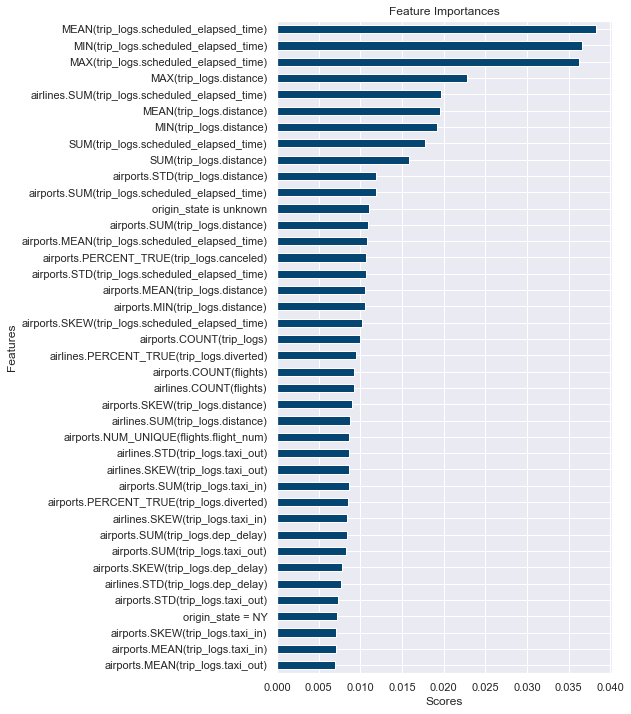

In [17]:
feature_importances = zip(x_train.columns, clf.feature_importances_)
feature_importances = pd.Series(dict(feature_importances))
feature_importances = feature_importances.rename_axis('Features')
feature_importances = feature_importances.sort_values()

top_features = feature_importances.tail(40)
plot = top_features.plot(kind='barh', figsize=(6, 12), color='#054571')
plot.set_title('Feature Importances')
plot.set_xlabel('Scores');